In [1]:
# -*- coding: utf-8 -*-

import meep as mp
import math
import numpy as np
import matplotlib.pyplot as plt

resolution = 50        # pixels/μm

dpml = 1.0             # PML thickness
dsub = 3.0             # substrate thickness
dpad = 3.0             # padding between grating and PML
gp = 10.0              # grating period
gh = 0.5               # grating height
gdc = 0.5              # grating duty cycle

sx = dpml+dsub+gh+dpad+dpml
sy = gp

cell_size = mp.Vector3(sx,sy,0)
pml_layers = [mp.PML(thickness=dpml,direction=mp.X)]

wvl_min = 0.4           # min wavelength
wvl_max = 0.6           # max wavelength
fmin = 1/wvl_max        # min frequency
fmax = 1/wvl_min        # max frequency
fcen = 0.5*(fmin+fmax)  # center frequency
df = fmax-fmin          # frequency width

src_pt = mp.Vector3(-0.5*sx+dpml+0.5*dsub)
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Ez, center=src_pt, size=mp.Vector3(y=sy))]

k_point = mp.Vector3(0,0,0)

glass = mp.Medium(index=1.5)

symmetries=[mp.Mirror(mp.Y)]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    k_point=k_point,
                    default_material=glass,
                    sources=sources,
                    symmetries=symmetries)

nfreq = 21
mon_pt = mp.Vector3(0.5*sx-dpml-0.5*dpad)
flux_mon = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy)))

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

input_flux = mp.get_fluxes(flux_mon)

sim.reset_meep()

geometry = [mp.Block(material=glass, size=mp.Vector3(dpml+dsub,mp.inf,mp.inf), center=mp.Vector3(-0.5*sx+0.5*(dpml+dsub))),
            mp.Block(material=glass, size=mp.Vector3(gh,gdc*gp,mp.inf), center=mp.Vector3(-0.5*sx+dpml+dsub+0.5*gh))]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    k_point=k_point,
                    sources=sources,
                    symmetries=symmetries)

mode_mon = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy)))

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

freqs = mp.get_eigenmode_freqs(mode_mon)

nmode = 10
res = sim.get_eigenmode_coefficients(mode_mon, range(1,nmode+1), eig_parity=mp.ODD_Z+mp.EVEN_Y)
coeffs = res.alpha
kdom = res.kdom

mode_wvl = []
mode_angle = []
mode_tran = []

for nm in range(nmode):
  for nf in range(nfreq):
    mode_wvl.append(1/freqs[nf])
    mode_angle.append(math.degrees(math.acos(kdom[nm*nfreq+nf].x/freqs[nf])))
    tran = abs(coeffs[nm,nf,0])**2/input_flux[nf]
    mode_tran.append(0.5*tran if nm != 0 else tran)
    print("grating{}:, {:.5f}, {:.2f}, {:.8f}".format(nm,mode_wvl[-1],mode_angle[-1],mode_tran[-1]))

tran_max = round(max(mode_tran),1)

-----------
Initializing structure...
field decay(t = 50.01): 0.10609306658233111 / 0.10609306658233111 = 1.0
field decay(t = 100.01): 8.493197174525773e-20 / 0.10609306658233111 = 8.005421511626135e-19
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
field decay(t = 50.01): 0.10313983544158939 / 0.10313983544158939 = 1.0
field decay(t = 100.01): 8.275841626039517e-06 / 0.10313983544158939 = 8.023904237006785e-05
field decay(t = 150.02): 7.578862246277832e-06 / 0.10313983544158939 = 7.348142658778942e-05
field decay(t = 200.03): 2.6331983132012556e-06 / 0.10313983544158939 = 2.55303714799167e-05
field decay(t = 250.04): 1.0595609940381617e-06 / 0.10313983544158939 = 1.0273052981921975e-05
field decay(t = 300.04): 4.182093600426132e-07 / 0.10313983544158939 = 4.054780175400371e-06
field decay(t = 350.05): 1.7897453529965382e-07 / 0.10313983544158939 = 1.7352610127152227e-06
field decay(t = 400.06): 7.323581231103283e-08 / 0.10313983544158939 = 7.10063

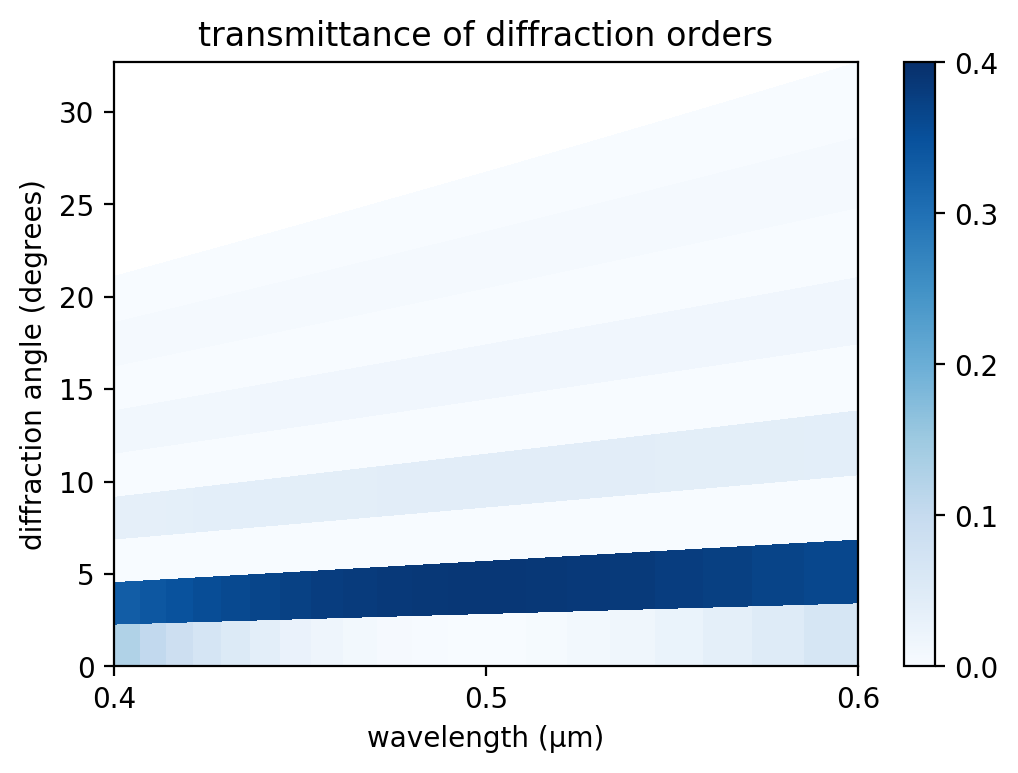

In [2]:
plt.figure(dpi=200)
plt.pcolormesh(np.reshape(mode_wvl,(nmode,nfreq)),
               np.reshape(mode_angle,(nmode,nfreq)),
               np.reshape(mode_tran,(nmode,nfreq)),
               cmap='Blues',
               shading='flat',
               vmin=0,
               vmax=tran_max)
plt.axis([min(mode_wvl), max(mode_wvl), min(mode_angle), max(mode_angle)])
plt.xlabel("wavelength (μm)")
plt.ylabel("diffraction angle (degrees)")
plt.xticks([t for t in np.linspace(wvl_min,wvl_max,3)])
plt.yticks([t for t in range(0,35,5)])
plt.title("transmittance of diffraction orders")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.arange(0,tran_max+0.1,0.1)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.arange(0,tran_max+0.1,0.1)])